In [1]:
!pip3 install lightning einops

In [15]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms
import pytorch_lightning as pl
from torchmetrics import Accuracy, F1Score, Precision, Recall
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import numpy as np
from einops.layers.torch import Rearrange
from einops import repeat, rearrange
from einops import repeat

In [3]:
# Check if GPU is available
import torch
gpu_available = torch.cuda.is_available()
print("GPU Available:", gpu_available)

import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"Number of available CPU cores: {num_cores}")


GPU Available: True
Number of available CPU cores: 8


In [4]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # This will normalize the values to [0, 1]
        ])

    def prepare_data(self):
        # Download datasets
        datasets.FashionMNIST(root='', train=True, download=False)
        datasets.FashionMNIST(root='', train=False, download=False)

    def setup(self, stage=None):
        # Load data
        full_train_dataset = datasets.FashionMNIST(root='', train=True, transform=self.transform)
        train_idx, val_idx = train_test_split(
            range(len(full_train_dataset)),
            test_size=0.1,
            shuffle=True,
            stratify=full_train_dataset.targets
        )
        
        self.train_dataset = Subset(full_train_dataset, train_idx)
        self.val_dataset = Subset(full_train_dataset, val_idx)
        self.test_dataset = datasets.FashionMNIST(root='', train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=8, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, num_workers=8, pin_memory=True)

In [16]:
from pytorch_lightning import Callback
import time

class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.reset_metrics()

    def reset_metrics(self):
        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        self.train_f1 = []
        self.val_f1 = []
        self.train_precision = []
        self.val_precision = []
        self.train_recall = []
        self.val_recall = []

    def on_train_epoch_end(self, trainer, pl_module):
        self.train_losses.append(trainer.callback_metrics['train_loss'].item())
        self.train_acc.append(trainer.callback_metrics['train_acc'].item())
        self.train_f1.append(trainer.callback_metrics['train_f1'].item())
        self.train_precision.append(trainer.callback_metrics['train_precision'].item())
        self.train_recall.append(trainer.callback_metrics['train_recall'].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        self.val_losses.append(trainer.callback_metrics['val_loss'].item())
        self.val_acc.append(trainer.callback_metrics['val_acc'].item())
        self.val_f1.append(trainer.callback_metrics['val_f1'].item())
        self.val_precision.append(trainer.callback_metrics['val_precision'].item())
        self.val_recall.append(trainer.callback_metrics['val_recall'].item())

    def get_metrics(self):
        return {
            "train_losses": self.train_losses,
            "val_losses": self.val_losses,
            "train_acc": self.train_acc,
            "val_acc": self.val_acc,
            "train_f1": self.train_f1,
            "val_f1": self.val_f1,
            "train_precision": self.train_precision,
            "val_precision": self.val_precision,
            "train_recall": self.train_recall,
            "val_recall": self.val_recall,
        }

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")


def model_monitor(train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, train_precision, val_precision, train_recall, val_recall):
    red    = '#FF6347'
    orange = "orange"
    blue   = '#4682B4'
    green  = "#55A868"
    purple = "#800080"
    cyan   = "#00FFFF"

    fig, ax = plt.subplots(2, 2, figsize=(20, 12))
    
    # Loss
    sns.lineplot(x=range(1, len(train_losses) + 1), y=train_losses, label='Train Loss', color=blue, ax=ax[0, 0])
    sns.lineplot(x=range(1, len(val_losses) + 1), y=val_losses, label='Validation Loss', color=green, ax=ax[0, 0])
    ax[0, 0].set_title('Training vs. Validation Loss', fontsize=16, fontweight='bold')
    ax[0, 0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[0, 0].set_ylabel('Loss', fontsize=12, fontweight='bold')
    ax[0, 0].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[0, 0].grid(True)

    # Accuracy
    sns.lineplot(x=range(1, len(train_acc) + 1), y=train_acc, label='Train Accuracy', color=orange, ax=ax[0, 1])
    sns.lineplot(x=range(1, len(val_acc) + 1), y=val_acc, label='Validation Accuracy', color=purple, ax=ax[0, 1])
    ax[0, 1].set_title('Training vs. Validation Accuracy', fontsize=16, fontweight='bold')
    ax[0, 1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[0, 1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax[0, 1].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[0, 1].grid(True)

    # F1 Score
    sns.lineplot(x=range(1, len(train_f1) + 1), y=train_f1, label='Train F1 Score', color=cyan, ax=ax[1, 0])
    sns.lineplot(x=range(1, len(val_f1) + 1), y=val_f1, label='Validation F1 Score', color=red, ax=ax[1, 0])
    ax[1, 0].set_title('Training vs. Validation F1 Score', fontsize=16, fontweight='bold')
    ax[1, 0].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[1, 0].set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax[1, 0].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[1, 0].grid(True)

    # Precision and Recall
    sns.lineplot(x=range(1, len(train_precision) + 1), y=train_precision, label='Train Precision', color=blue, ax=ax[1, 1])
    sns.lineplot(x=range(1, len(val_precision) + 1), y=val_precision, label='Validation Precision', color=green, ax=ax[1, 1])
    sns.lineplot(x=range(1, len(train_recall) + 1), y=train_recall, label='Train Recall', color=orange, ax=ax[1, 1])
    sns.lineplot(x=range(1, len(val_recall) + 1), y=val_recall, label='Validation Recall', color=purple, ax=ax[1, 1])
    ax[1, 1].set_title('Training vs. Validation Precision and Recall', fontsize=16, fontweight='bold')
    ax[1, 1].set_xlabel('Epochs', fontsize=12, fontweight='bold')
    ax[1, 1].set_ylabel('Score', fontsize=12, fontweight='bold')
    ax[1, 1].legend(facecolor='white', fontsize=12, title_fontsize='11', edgecolor='black')
    ax[1, 1].grid(True)

    plt.tight_layout()
    plt.show();

## ***`ViT Lecture with Conv Layer for Embedding`***
---

In [18]:
# Patch and Embedding setup
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_size):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Sequential(
            nn.Conv2d(in_channels, embed_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e')
        )
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, embed_size))

    def forward(self, x):
        b, _, _, _ = x.shape
        x = self.proj(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.positions
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attn = nn.MultiheadAttention(embed_dim=embed_size, num_heads=heads, dropout=dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.mlp = nn.Sequential(
            nn.Linear(embed_size, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_size),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm1(x)
        x = x.permute(1, 0, 2)  # adjust for nn.MultiheadAttention
        attn_output, _ = self.attn(x, x, x)
        attn_output = attn_output.permute(1, 0, 2)  # revert adjustment
        x = self.norm2(x.permute(1, 0, 2) + attn_output)
        x2 = self.mlp(x)
        return x + x2

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.1):
        super().__init__()
        self.heads = n_heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)
    
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))

    
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x
    
    
# Vision Transformer Full Model
class ViTConv(pl.LightningModule):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, num_classes=10, embed_size=64, depth=6, heads=8, mlp_dim=128, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_size)
        self.layers = nn.ModuleList([
            nn.Sequential(
                ResidualAdd(PreNorm(embed_size, Attention(embed_size, heads, dropout))),
                ResidualAdd(PreNorm(embed_size, FeedForward(embed_size, mlp_dim, dropout)))
            ) for _ in range(depth)
        ])
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_size), nn.Linear(embed_size, num_classes))
        self.loss_fn = nn.CrossEntropyLoss()

        self.train_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.val_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.test_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.train_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.val_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.test_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.train_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.val_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.test_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.train_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.val_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.test_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')

    def forward(self, x):
        x = self.patch_embedding(x)
        for layer in self.layers:
            x = layer(x)
        return self.mlp_head(x[:, 0])

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.train_accuracy(logits, y)
        f1 = self.train_f1(logits, y)
        precision = self.train_precision(logits, y)
        recall = self.train_recall(logits, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.val_accuracy(logits, y)
        f1 = self.val_f1(logits, y)
        precision = self.val_precision(logits, y)
        recall = self.val_recall(logits, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('val_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.test_accuracy(logits, y)
        f1 = self.test_f1(logits, y)
        precision = self.test_precision(logits, y)
        recall = self.test_recall(logits, y)
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_f1', f1, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_precision', precision, on_step=True, on_epoch=True, prog_bar=True)
        self.log('test_recall', recall, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)


In [20]:
model = ViTConv()
callback = MetricsCallback()
data_module = FashionMNISTDataModule()
trainer = pl.Trainer(
    max_epochs=50,
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[callback]
)
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | patch_embedding | PatchEmbedding      | 4.4 K  | train
1  | layers          | ModuleList          | 199 K  | train
2  | mlp_head        | Sequential          | 778    | train
3  | loss_fn         | CrossEntropyLoss    | 0      | train
4  | train_accuracy  | MulticlassAccuracy  | 0      | train
5  | val_accuracy    | MulticlassAccuracy  | 0      | train
6  | test_accuracy   | MulticlassAccuracy  | 0      | train
7  | train_f1        | MulticlassF1Score   | 0      | train
8  | val_f1          | MulticlassF1Score   | 0      | train
9  | test_f1         | MulticlassF1Score   | 0      | train
10 | train_precision | MulticlassPrecision | 0      | train
11 | val_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8934360146522522
      test_f1_epoch         0.8841882944107056
     test_loss_epoch        0.3827449083328247
  test_precision_epoch      0.8943987488746643
    test_recall_epoch       0.8934360146522522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.3827449083328247,
  'test_acc_epoch': 0.8934360146522522,
  'test_f1_epoch': 0.8841882944107056,
  'test_precision_epoch': 0.8943987488746643,
  'test_recall_epoch': 0.8934360146522522}]

In [21]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     test_acc_epoch         0.8934360146522522
      test_f1_epoch         0.8841882944107056
     test_loss_epoch        0.3827449083328247
  test_precision_epoch      0.8943987488746643
    test_recall_epoch       0.8934360146522522
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss_epoch': 0.3827449083328247,
  'test_acc_epoch': 0.8934360146522522,
  'test_f1_epoch': 0.8841882944107056,
  'test_precision_epoch': 0.8943987488746643,
  'test_recall_epoch': 0.8934360146522522}]

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

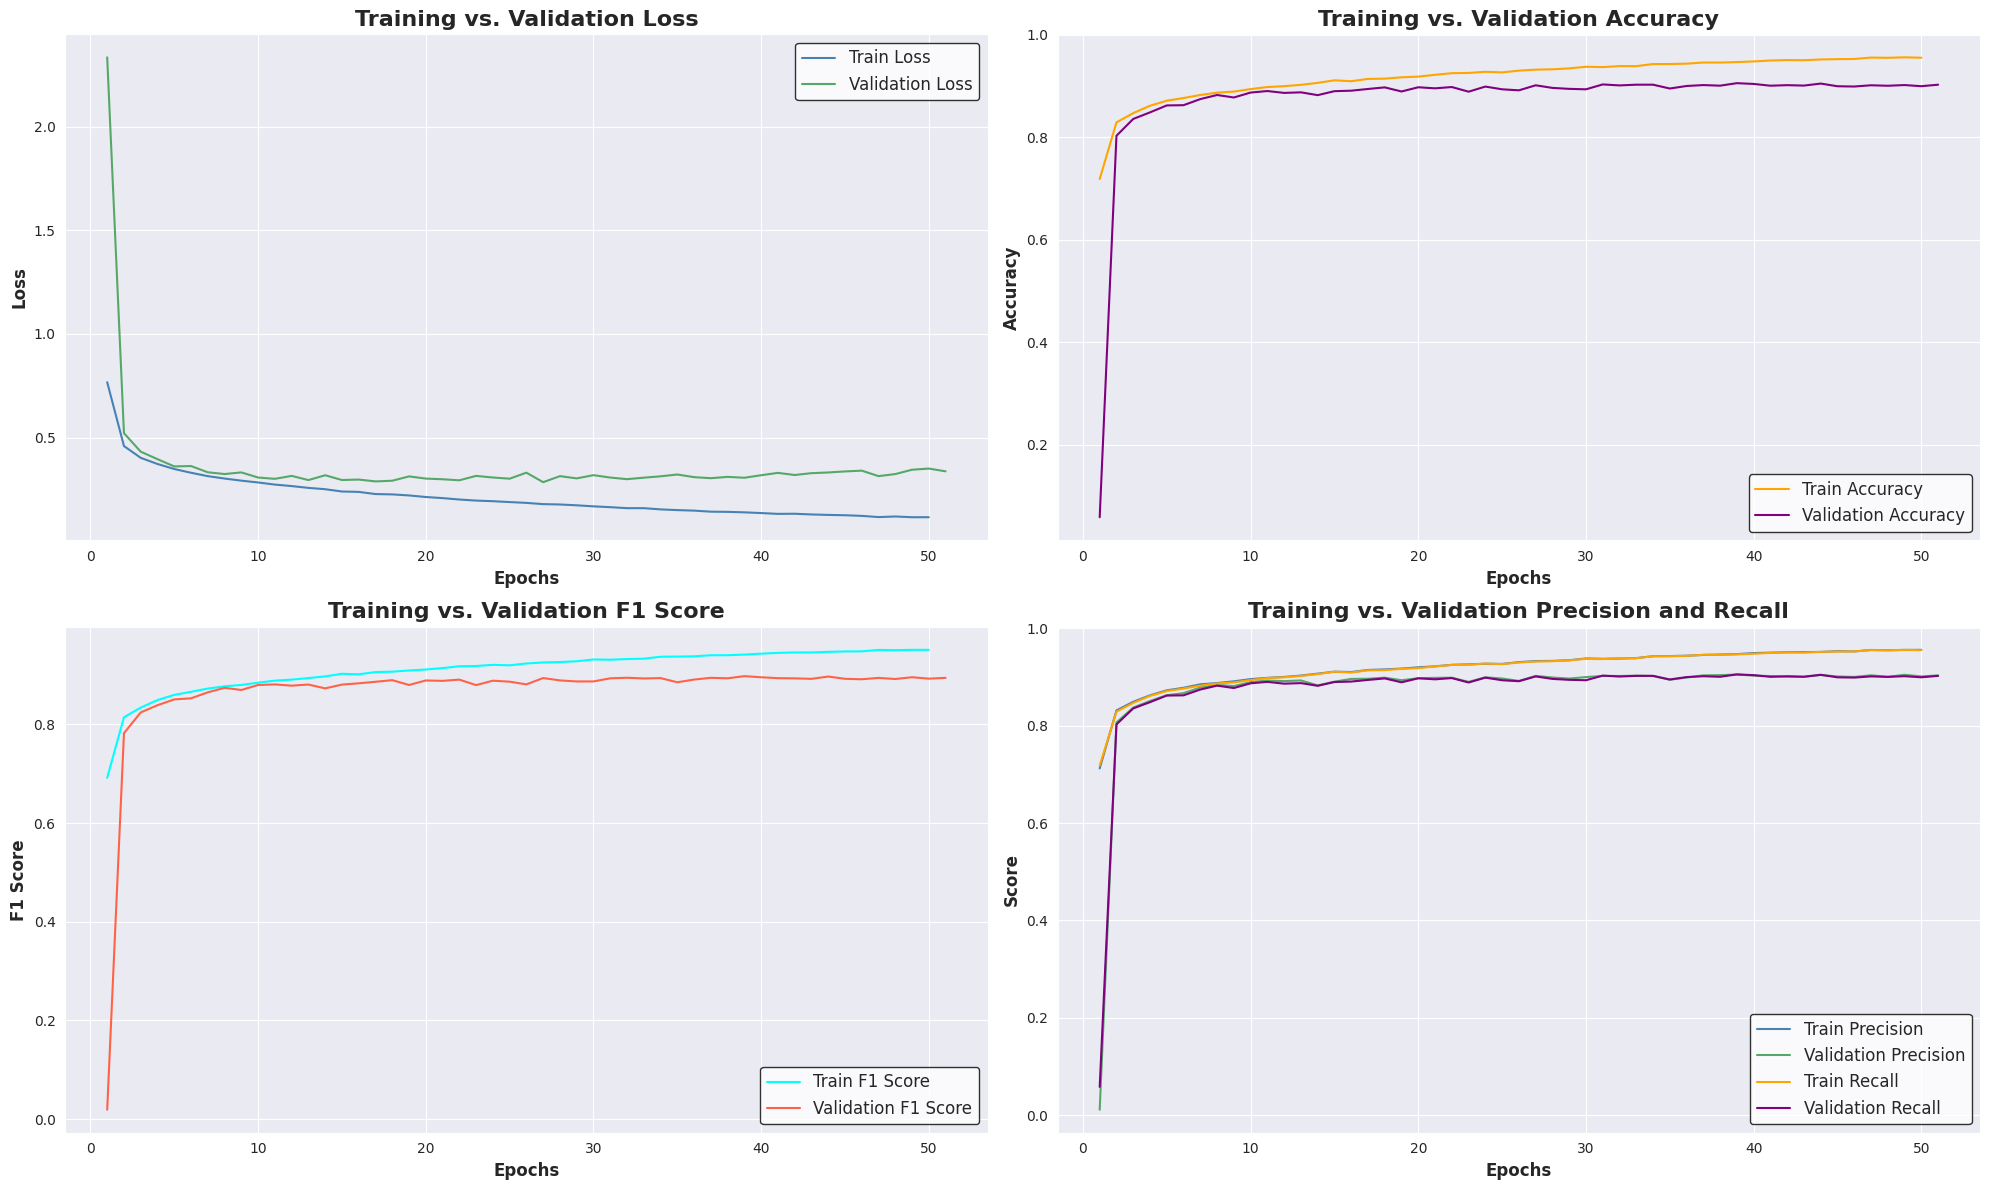

In [22]:
model_monitor(
    train_losses    = callback.train_losses,
    val_losses     = callback.val_losses,
    train_acc       = callback.train_acc,
    val_acc        = callback.val_acc,
    train_f1        = callback.train_f1,
    val_f1         = callback.val_f1,
    train_precision = callback.train_precision,
    val_precision  = callback.val_precision,
    train_recall    = callback.train_recall,
    val_recall     = callback.val_recall,
)

## ***`ViT YT with FF Layer for Embedding`***
---
- https://www.youtube.com/watch?v=j3VNqtJUoz0

In [28]:
import torch
from torch import nn
from torch.optim import Adam
from einops import repeat, rearrange
import pytorch_lightning as pl
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, F1Score, Precision, Recall


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size, embed_size):
        super().__init__()
        self.projection = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, embed_size)
        )

    def forward(self, x):
        return self.projection(x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_size)
        self.attn = Attention(embed_size, heads, dropout)
        self.norm2 = nn.LayerNorm(embed_size)
        self.mlp = FeedForward(embed_size, mlp_dim, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class Attention(nn.Module):
    def __init__(self, dim, n_heads, dropout=0.1):
        super().__init__()
        self.heads = n_heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=h), qkv)
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))

class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x
    


class ViTFForward(pl.LightningModule):
    def __init__(self, img_size=28, patch_size=4, in_channels=1, num_classes=10, embed_size=64, depth=6, heads=8, mlp_dim=128, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, embed_size)
        num_patches = (img_size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_size))
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.layers = nn.ModuleList([
            nn.Sequential(
                ResidualAdd(PreNorm(embed_size, Attention(embed_size, heads, dropout))),
                ResidualAdd(PreNorm(embed_size, FeedForward(embed_size, mlp_dim, dropout)))
            ) for _ in range(depth)
        ])
        self.mlp_head = nn.Sequential(nn.LayerNorm(embed_size), nn.Linear(embed_size, num_classes))
        self.loss_fn = nn.CrossEntropyLoss()
        # Metrics
        self.train_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.val_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.test_accuracy = Accuracy(num_classes=num_classes, average='macro', task='multiclass')
        self.train_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.val_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.test_f1 = F1Score(num_classes=num_classes, average='macro', task='multiclass')
        self.train_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.val_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.test_precision = Precision(num_classes=num_classes, average='macro', task='multiclass')
        self.train_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.val_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')
        self.test_recall = Recall(num_classes=num_classes, average='macro', task='multiclass')

    
    def forward(self, img):
        x = self.patch_embedding(img)
        b, n, _ = x.shape
        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat([cls_tokens, x], dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        for layer in self.layers:
            x = layer(x)
        return self.mlp_head(x[:, 0])

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.train_accuracy(logits, y)
        f1 = self.train_f1(logits, y)
        precision = self.train_precision(logits, y)
        recall = self.train_recall(logits, y)
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        self.log('train_f1', f1)
        self.log('train_precision', precision)
        self.log('train_recall', recall)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.val_accuracy(logits, y)
        f1 = self.val_f1(logits, y)
        precision = self.val_precision(logits, y)
        recall = self.val_recall(logits, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        self.log('val_f1', f1)
        self.log('val_precision', precision)
        self.log('val_recall', recall)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss_fn(logits, y)
        acc = self.test_accuracy(logits, y)
        f1 = self.test_f1(logits, y)
        precision = self.test_precision(logits, y)
        recall = self.test_recall(logits, y)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        self.log('test_f1', f1)
        self.log('test_precision', precision)
        self.log('test_recall', recall)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

In [29]:
model       = ViTFForward()
callback    = MetricsCallback()
data_module = FashionMNISTDataModule()

trainer = pl.Trainer(
    max_epochs=50,
    precision="16-mixed",
    devices=1 if torch.cuda.is_available() else 1,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    callbacks=[callback]
)
trainer.fit(model, datamodule=data_module)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | patch_embedding | PatchEmbedding      | 1.1 K  | train
1  | layers          | ModuleList          | 199 K  | train
2  | mlp_head        | Sequential          | 778    | train
3  | loss_fn         | CrossEntropyLoss    | 0      | train
4  | train_accuracy  | MulticlassAccuracy  | 0      | train
5  | val_accuracy    | MulticlassAccuracy  | 0      | train
6  | test_accuracy   | MulticlassAccuracy  | 0      | train
7  | train_f1        | MulticlassF1Score   | 0      | train
8  | val_f1          | MulticlassF1Score   | 0      | train
9  | test_f1         | MulticlassF1Score   | 0      | train
10 | train_precision | MulticlassPrecision | 0      | train
11 | val_pr

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [30]:
trainer.test(model, datamodule=data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8988519310951233
         test_f1            0.8896877765655518
        test_loss           0.36189910769462585
     test_precision         0.8989101648330688
       test_recall          0.8988519310951233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.36189910769462585,
  'test_acc': 0.8988519310951233,
  'test_f1': 0.8896877765655518,
  'test_precision': 0.8989101648330688,
  'test_recall': 0.8988519310951233}]